In [2]:
import sys
import os

# Add the root directory to sys.path
sys.path.append(os.path.abspath(".."))

Epoch 100/100: 100%|██████████| 100/100 [00:00<00:00, 1142.86it/s]


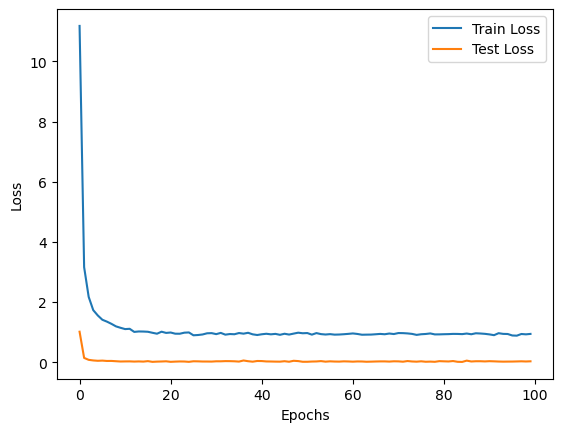

Model training completed successfully. Weights have been saved as 'mc_dropout_mass_spring_damper.pth' in the 'weights' directory.


In [6]:
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv
from models.mc_dropout_bnn import MCDropoutBNN_Wrapper
from sampling_methods.random_exploration import random_exploration
from train import create_dataloader

import torch
import os

env = MassSpringDamperEnv(nlin=True)

# Hyperparameters
HORIZON = 5000
BATCH_SIZE = 50
NUM_EPOCHS = 100
LEARNING_RATE = 1e-3
HIDDEN_SIZE = 64

# Collect data from the environment
train_dataset = random_exploration(env, HORIZON)
# Create DataLoader for training
train_dataloader = create_dataloader(train_dataset, BATCH_SIZE)
# Collect data for test set
test_dataset = random_exploration(env, 500)
# Create DataLoader for training
test_dataloader = create_dataloader(test_dataset, 500)

# Initialize the dynamics model
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
model = MCDropoutBNN_Wrapper(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

# Train the model
model.train_model(train_dataloader, test_dataloader, NUM_EPOCHS, plot=True)

# Ensure the 'weights' directory exists
os.makedirs('../weights', exist_ok=True)

# Save the trained model
torch.save(model.model.state_dict(), '../weights/mc_dropout_mass_spring_damper.pth')
print("Model training completed successfully. "
      "Weights have been saved as 'mc_dropout_mass_spring_damper.pth' in the 'weights' directory.")

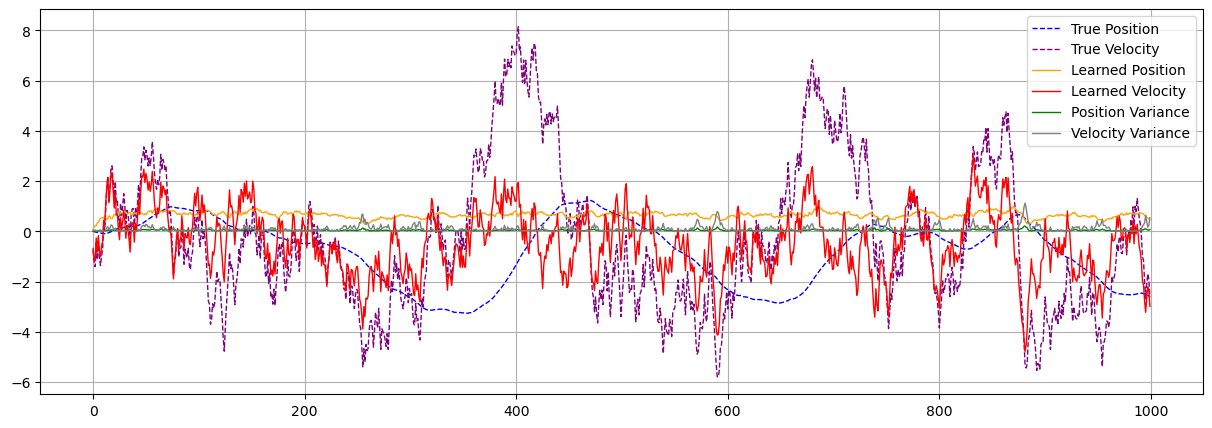

In [7]:
# test model
from dynamical_systems.mass_spring_damper_system import MassSpringDamperEnv

import numpy as np
import pygame
import matplotlib.pyplot as plt

# set random seed to get same test trajectory
test_seed = 44

# Using trained model as system dynamic
if __name__ == "__main__":
    # Initialize trained dynamics model
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    trained_model = MCDropoutBNN_Wrapper(state_dim, action_dim, hidden_size=HIDDEN_SIZE)

    # load saved weights
    trained_model.load_state_dict(torch.load('../weights/mc_dropout_mass_spring_damper.pth'))

    # learned dynamic
    trained_env = MassSpringDamperEnv(model=trained_model)
    trained_env.reset()
    env.reset()
    env.action_space.seed(test_seed)
    env.action_space.seed(test_seed)
    save = [[],[],[]]
    save_var = []
    # clock = pygame.time.Clock()
    for _ in range(1000):
        action = env.action_space.sample()
        obs, _, _, _, _= env.step(action)
        save[0].append(obs)
        obs, _, _, _, info= trained_env.step(action)
        save[1].append(obs)
        save[2].append(info['var'])
        # clock.tick(400)
trained_env.close()

saved_traj = np.array(save)
plt.figure(1, (15,5))
plt.plot(saved_traj[0,:,0], label="True Position", color="blue", linestyle="--", linewidth=1)
plt.plot(saved_traj[0,:,1], label="True Velocity", color="purple", linestyle="--", linewidth=1)
plt.plot(saved_traj[1,:,0], label="Learned Position", color="orange", linewidth=1)
plt.plot(saved_traj[1,:,1], label="Learned Velocity", color="red", linewidth=1)
plt.plot(saved_traj[2,:,0], label="Position Variance", color="green", linewidth=1)
plt.plot(saved_traj[2,:,1], label="Velocity Variance", color="gray", linewidth=1)
plt.legend()
plt.grid(True)
plt.show()